In [2]:
#!pip install h5py

In [9]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [10]:
file_path = "MJD_Train_10.hdf5"

✅ Selected Waveforms:
All-True waveform → ID: 2395098
Mostly-False waveform → ID: 2395281


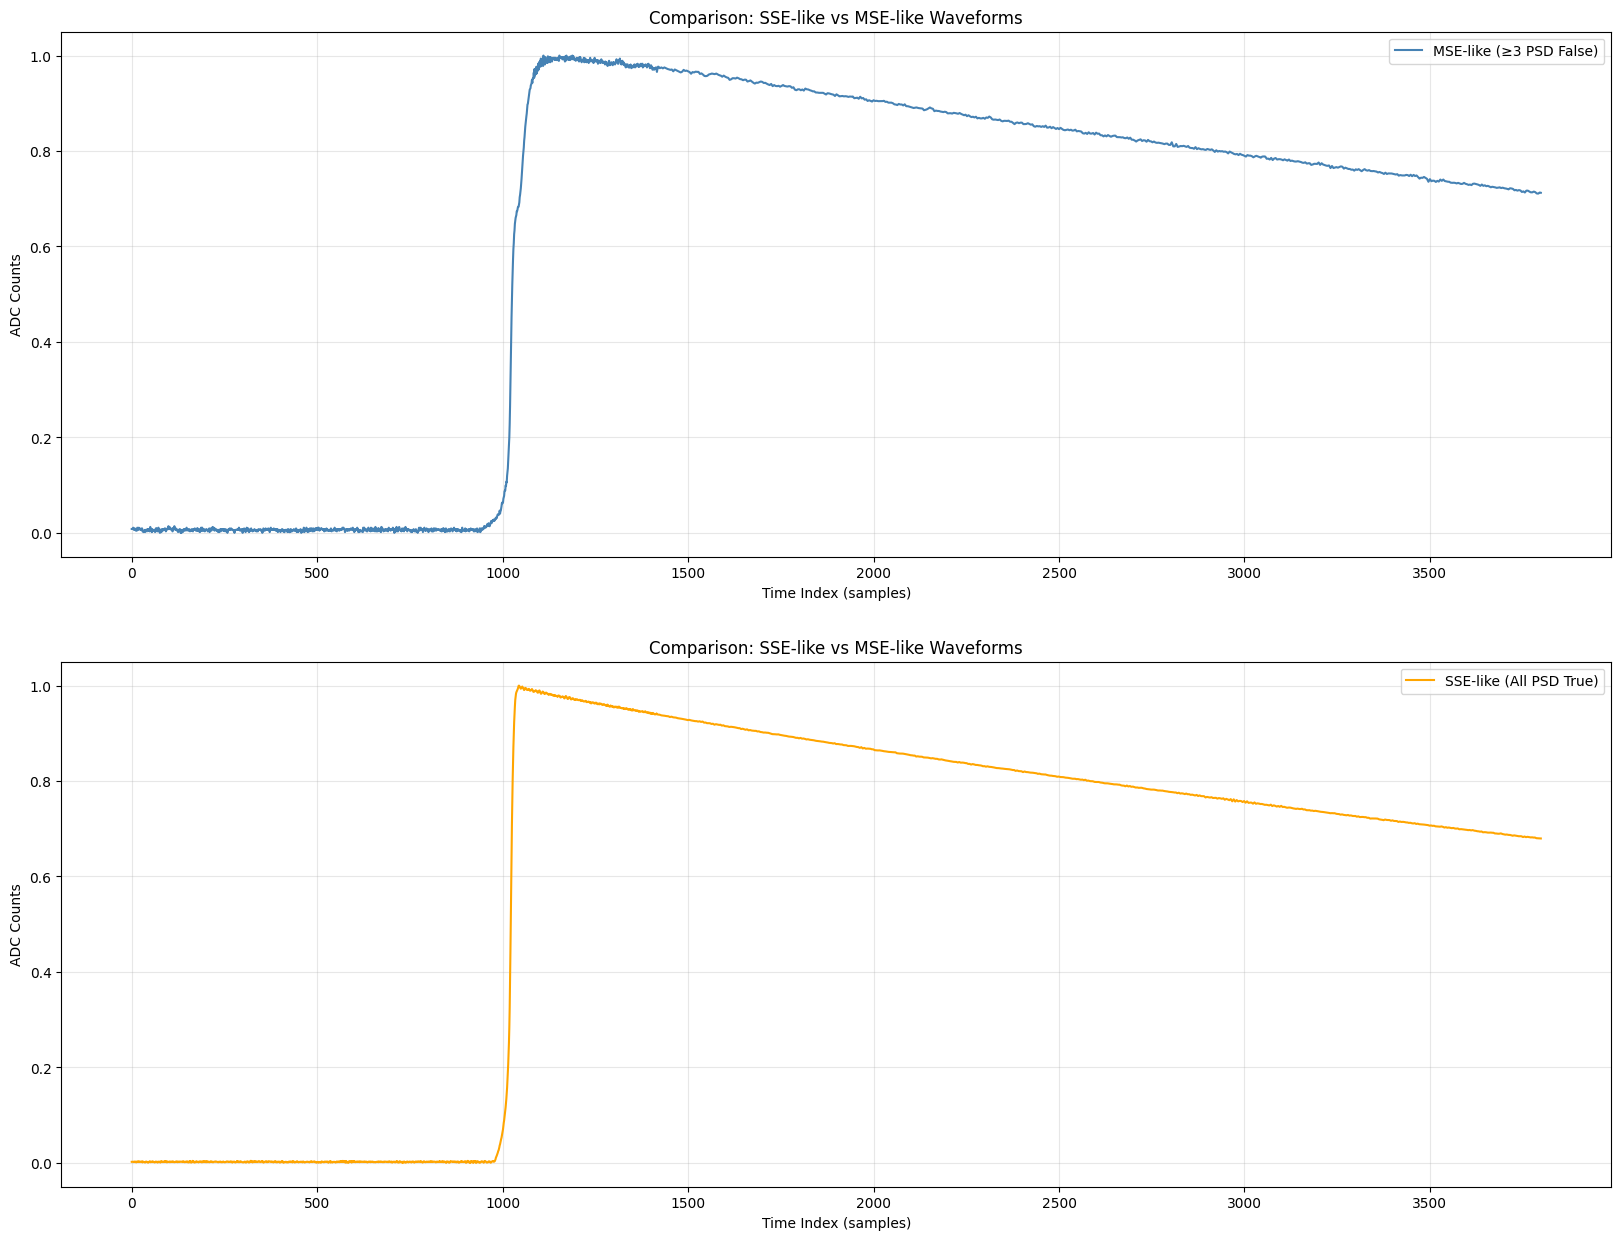

In [65]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

file_path = "MJD_Test_0.hdf5"

# --- Load waveform and labels ---
with h5py.File(file_path, 'r') as file:
    raw_waveform = np.array(file["raw_waveform"])
    time_index = np.arange(0, raw_waveform.shape[1])

    energy_label = np.array(file["energy_label"])
    psd_label_low_avse = np.array(file["psd_label_low_avse"])
    psd_label_high_avse = np.array(file["psd_label_high_avse"])
    psd_label_dcr = np.array(file["psd_label_dcr"])
    psd_label_lq = np.array(file["psd_label_lq"])
    tp0 = np.array(file["tp0"])
    detector = np.array(file["detector"])
    run_number = np.array(file["run_number"])
    ids = np.array(file["id"])

# --- Combine PSD labels into single array for easier filtering ---
psd_matrix = np.vstack([
    psd_label_low_avse,
    psd_label_high_avse,
    psd_label_dcr,
    psd_label_lq
]).T  # shape (num_waveforms, 4)

# --- Find index where all 4 PSD labels are True ---
all_true_mask = np.all(psd_matrix == True, axis=1)

# --- Find index where at least 3 out of 4 PSD labels are False ---
mostly_false_mask = np.sum(psd_matrix == False, axis=1) >= 3

# --- Select examples ---
if np.any(all_true_mask):
    true_idx = np.where(all_true_mask)[0][0]
else:
    raise ValueError("No waveform found where all PSD labels are True.")

if np.any(mostly_false_mask):
    false_idx = np.where(mostly_false_mask)[0][0]
else:
    raise ValueError("No waveform found where ≥3 PSD labels are False.")

# --- Extract waveforms ---
true_waveform = raw_waveform[true_idx]
false_waveform = raw_waveform[false_idx]

print("✅ Selected Waveforms:")
print(f"All-True waveform → ID: {ids[true_idx]}")
print(f"Mostly-False waveform → ID: {ids[false_idx]}")

wf_norm_sse = (true_waveform - np.min(true_waveform)) / (np.max(true_waveform) - np.min(true_waveform))
wf_norm_mse = (false_waveform - np.min(false_waveform)) / (np.max(false_waveform) - np.min(false_waveform))

# --- Plot both for comparison ---
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20,15))
axes[0].plot(time_index, wf_norm_mse, label='MSE-like (≥3 PSD False)', color='steelblue')
axes[0].set_title("Comparison: SSE-like vs MSE-like Waveforms")
axes[0].set_xlabel("Time Index (samples)")
axes[0].set_ylabel("ADC Counts")
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(time_index, wf_norm_sse, label='SSE-like (All PSD True)', color='orange')
axes[1].set_title("Comparison: SSE-like vs MSE-like Waveforms")
axes[1].set_xlabel("Time Index (samples)")
axes[1].set_ylabel("ADC Counts")
axes[1].legend()
axes[1].grid(alpha=0.3)
plt.show()


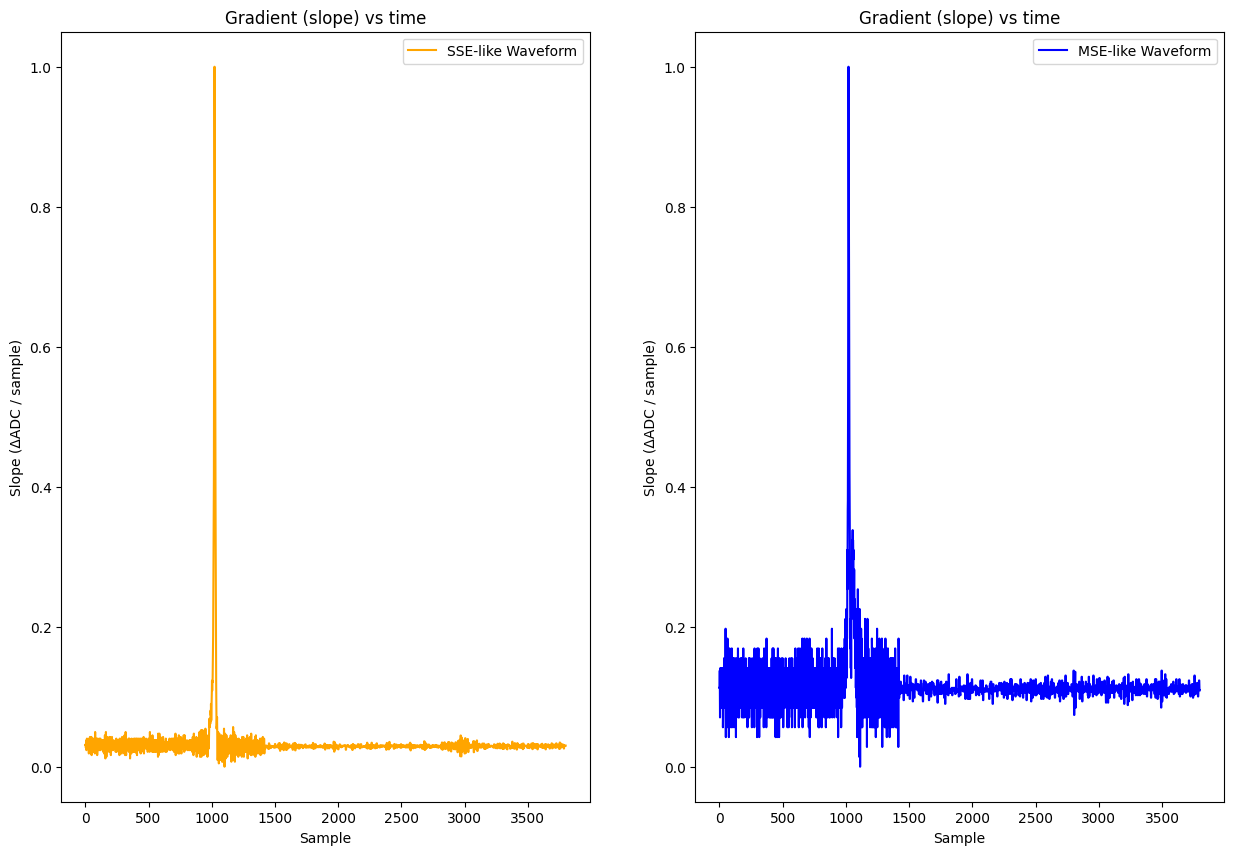

0.005991302111073516
0.027580383742871976


In [67]:
def gradient_trace(wf):
    """
    First difference (slope) as a simple current proxy.
    Returns the slope series and a few summary stats.
    """
    g = np.gradient(wf)
    stats = {
        "max_grad": np.max(g),
        "rms_grad": np.sqrt(np.mean(g**2)),
        "grad_spread": np.percentile(np.abs(g), 95) - np.percentile(np.abs(g), 5)
    }
    return g, stats

def compare_transforms(wf_sse, wf_mse, time_index, smooth_sigma=1.0):
    # ---------- 2) Gradient (slope) ----------
    g_sse, stats_sse = gradient_trace(true_waveform)
    g_mse, stats_mse = gradient_trace(false_waveform)

    wf_norm_sse = (g_sse - np.min(g_sse)) / (np.max(g_sse) - np.min(g_sse))
    wf_norm_mse = (g_mse - np.min(g_mse)) / (np.max(g_mse) - np.min(g_mse))


    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 10)) # Adjust figsize as needed
    axes[0].plot(time_index, wf_norm_sse, label='SSE-like Waveform', color='orange')    
    axes[0].set_title("Gradient (slope) vs time")
    axes[0].set_xlabel("Sample")
    axes[0].set_ylabel("Slope (ΔADC / sample)")
    axes[0].legend()

    axes[1].plot(time_index, wf_norm_mse, label='MSE-like Waveform', color='blue')
    axes[1].set_title("Gradient (slope) vs time")
    axes[1].set_xlabel("Sample")
    axes[1].set_ylabel("Slope (ΔADC / sample)")
    axes[1].legend()
    plt.show()

    print(wf_norm_sse[:900].std())
    print(wf_norm_mse[:900].std())

compare_transforms(true_waveform, false_waveform, time_index)

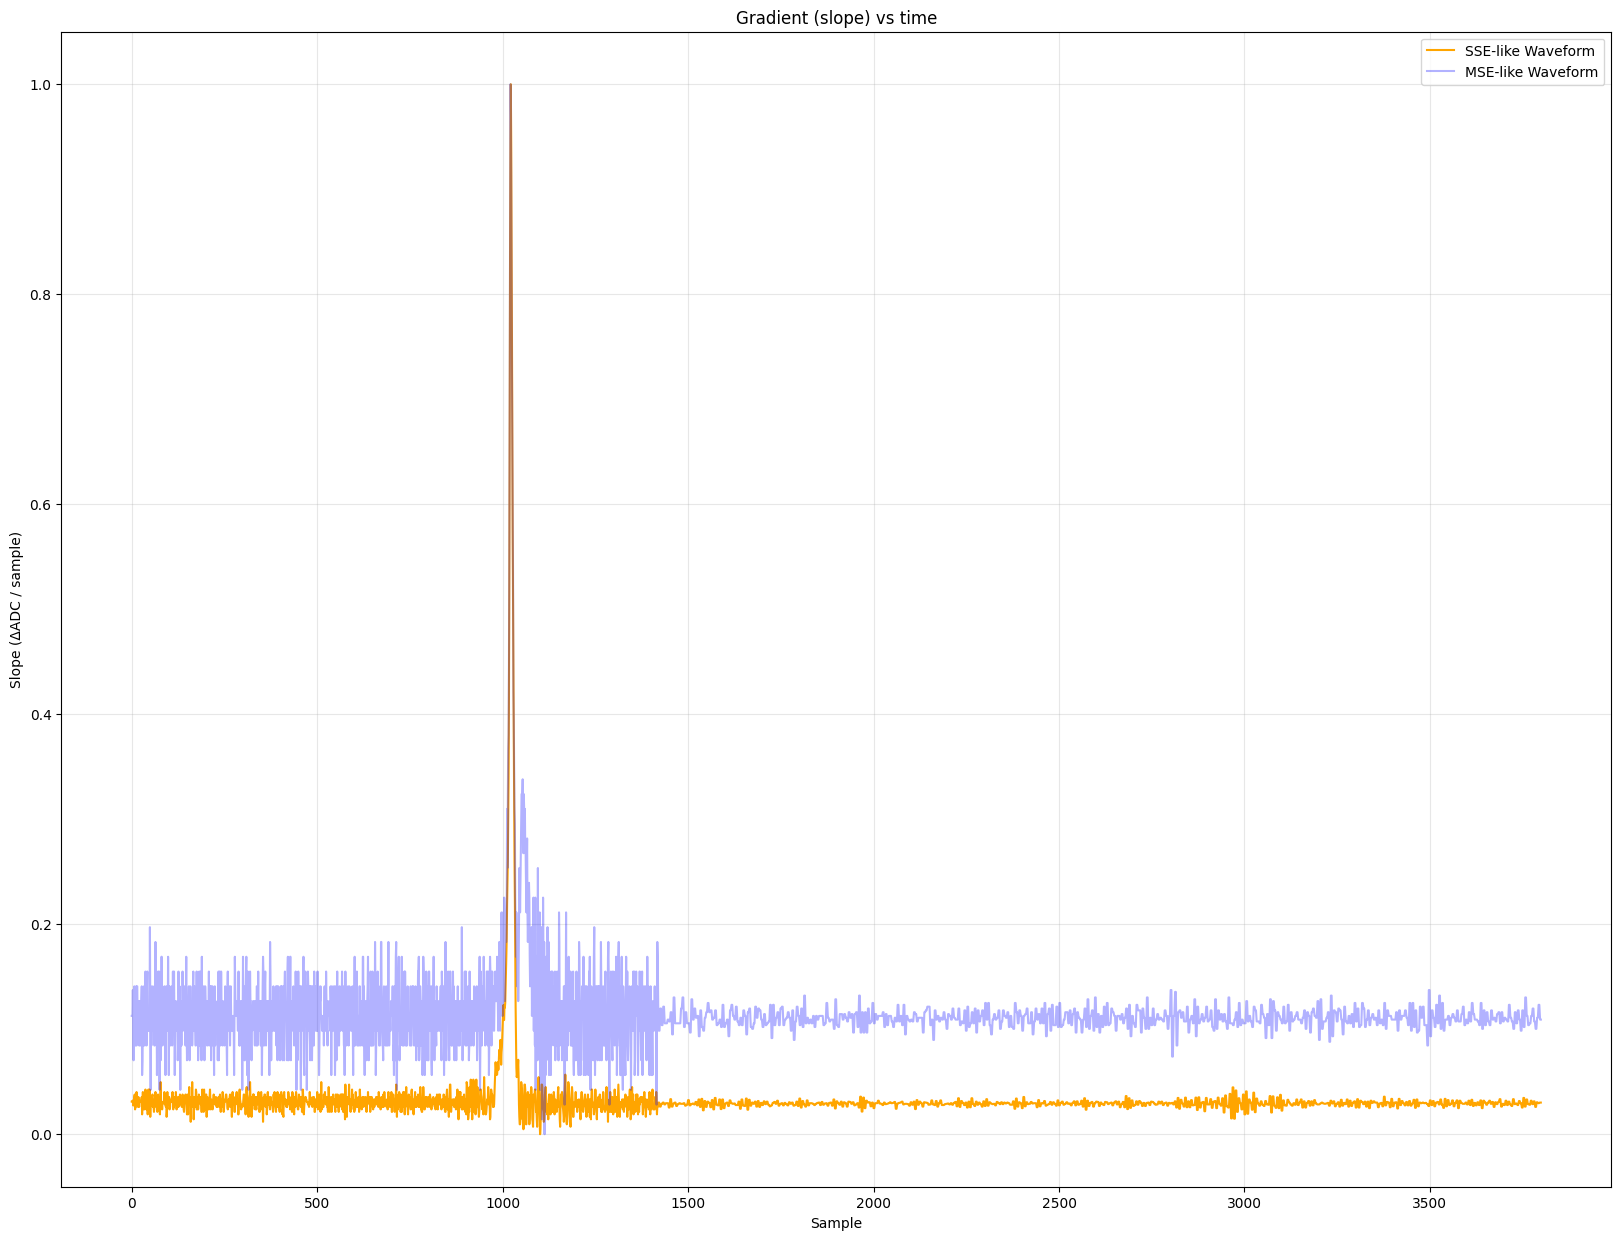

0.003225219068417155
0.44969262068871674


In [64]:
def compare_transforms(wf_sse, wf_mse, time_index, smooth_sigma=1.0):
    # ---------- 2) Gradient (slope) ----------
    g_sse, stats_sse = gradient_trace(true_waveform)
    g_mse, stats_mse = gradient_trace(false_waveform)

    wf_norm_sse = (g_sse - np.min(g_sse)) / (np.max(g_sse) - np.min(g_sse))
    wf_norm_mse = (g_mse - np.min(g_mse)) / (np.max(g_mse) - np.min(g_mse))

    plt.figure(figsize=(20, 15))
    plt.plot(time_index, wf_norm_sse, label='SSE-like Waveform', color='orange')
    plt.plot(time_index, wf_norm_mse, label='MSE-like Waveform', color='blue', alpha = 0.3)  
    plt.title("Gradient (slope) vs time")
    plt.xlabel("Sample")
    plt.ylabel("Slope (ΔADC / sample)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    print(wf_norm_sse[1200:].std())
    print(g_mse[1200:].std())

compare_transforms(true_waveform, false_waveform, time_index)

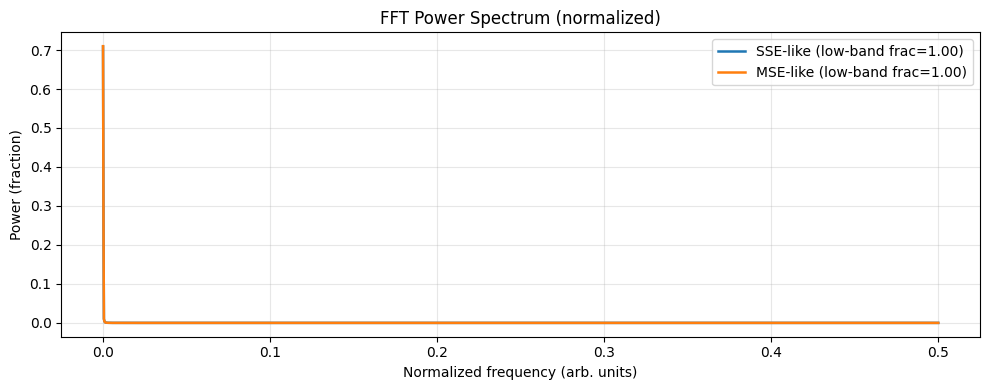

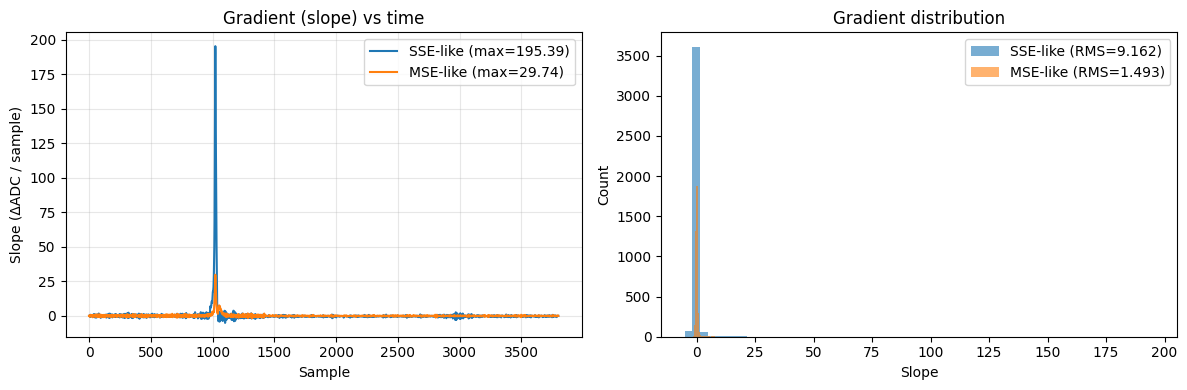

/var/folders/43/kk5s6cn52lv1g9lf0yhbq2r80000gn/T/ipykernel_54249/1261584449.py:142: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


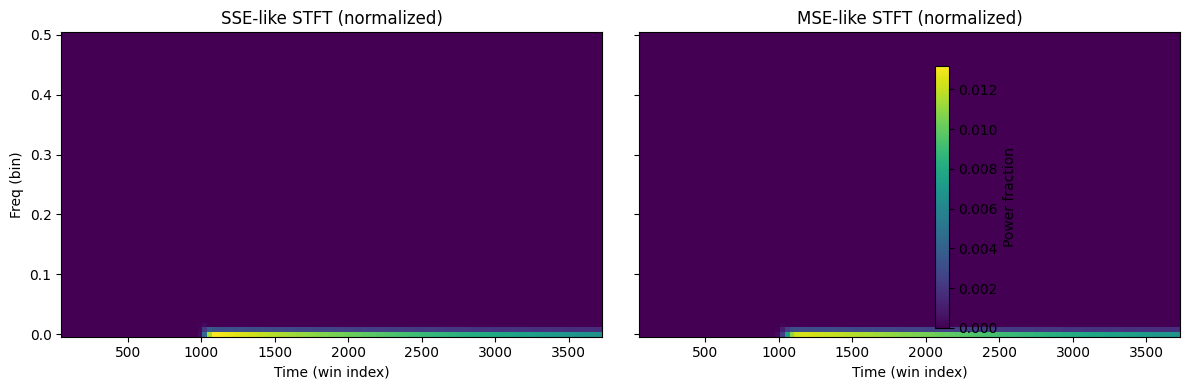

=== Summary metrics (normalized comparisons) ===
SSE-like: low-band power fraction (first 25% bins): 1.000
MSE-like: low-band power fraction (first 25% bins): 1.000
SSE-like gradient: max=195.391, RMS=9.162, spread=1.654
MSE-like gradient: max=29.743, RMS=1.493, spread=0.939


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import get_window, stft
from scipy.ndimage import gaussian_filter1d

# ---------------------------------------------------------
# Helpers
# ---------------------------------------------------------

def preprocess(wf, smooth_sigma=1.0):
    """
    Lightly smooth the waveform (optional) to suppress digitizer noise
    without blurring pulse shape.
    """
    if smooth_sigma and smooth_sigma > 0:
        wf_s = gaussian_filter1d(wf.astype(float), sigma=smooth_sigma)
    else:
        wf_s = wf.astype(float)
    return wf_s

def fft_power_spectrum(wf, window_name='hann'):
    """
    Window -> FFT -> one-sided power spectrum, normalized so total power = 1.
    """
    N = len(wf)
    window = get_window(window_name, N, fftbins=True)
    wf_w = wf * window

    # one-sided FFT
    fft_vals = np.fft.rfft(wf_w)
    power = np.abs(fft_vals)**2

    # normalize to compare across events
    power /= (power.sum() + 1e-12)

    freqs = np.fft.rfftfreq(N, d=1.0)  # d=1 sample spacing; OK for relative compare
    return freqs, power

def gradient_trace(wf):
    """
    First difference (slope) as a simple current proxy.
    Returns the slope series and a few summary stats.
    """
    g = np.gradient(wf)
    stats = {
        "max_grad": np.max(g),
        "rms_grad": np.sqrt(np.mean(g**2)),
        "grad_spread": np.percentile(np.abs(g), 95) - np.percentile(np.abs(g), 5)
    }
    return g, stats

def stft_spectrogram(wf, nperseg=128, noverlap=96):
    """
    Short-Time Fourier Transform for time–frequency view.
    Normalize the spectrogram so each event is comparable.
    """
    f, t, Zxx = stft(wf, nperseg=nperseg, noverlap=noverlap, padded=False, boundary=None)
    S = np.abs(Zxx)**2
    S /= (S.sum() + 1e-12)     # normalize total energy
    return f, t, S

def total_power_band(freqs, power, fmax_frac=0.25):
    """
    Simple metric: fraction of power in the lowest frequencies.
    fmax_frac=0.25 → lowest 25% of the frequency axis.
    """
    cut = int(len(freqs) * fmax_frac)
    return power[:cut].sum()

# ---------------------------------------------------------
# Main compare function (call once with your two waveforms)
# ---------------------------------------------------------

def compare_transforms(wf_sse, wf_mse, time_index, smooth_sigma=1.0):
    # ---------- 0) Preprocess ----------
    sse = preprocess(wf_sse, smooth_sigma=smooth_sigma)
    mse = preprocess(wf_mse, smooth_sigma=smooth_sigma)

    # ---------- 1) FFT Power ----------
    f_sse, P_sse = fft_power_spectrum(sse)
    f_mse, P_mse = fft_power_spectrum(mse)

    lowpow_sse = total_power_band(f_sse, P_sse, fmax_frac=0.25)
    lowpow_mse = total_power_band(f_mse, P_mse, fmax_frac=0.25)
    totpow_sse = P_sse.sum()   # = 1 by construction
    totpow_mse = P_mse.sum()   # = 1 by construction

    # ---------- 2) Gradient (slope) ----------
    g_sse, stats_sse = gradient_trace(sse)
    g_mse, stats_mse = gradient_trace(mse)

    # ---------- 3) STFT Spectrogram ----------
    F_sse, T_sse, S_sse = stft_spectrogram(sse)
    F_mse, T_mse, S_mse = stft_spectrogram(mse)

    # -------------------- Plots --------------------

    # A) Power spectra
    plt.figure(figsize=(10,4))
    plt.plot(f_sse, P_sse, label=f"SSE-like (low-band frac={lowpow_sse:.2f})", lw=1.8)
    plt.plot(f_mse, P_mse, label=f"MSE-like (low-band frac={lowpow_mse:.2f})", lw=1.8)
    plt.title("FFT Power Spectrum (normalized)")
    plt.xlabel("Normalized frequency (arb. units)")
    plt.ylabel("Power (fraction)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # B) Gradient traces (overlay) + histograms
    fig, ax = plt.subplots(1,2, figsize=(12,4))
    ax[0].plot(time_index, g_sse, label=f"SSE-like (max={stats_sse['max_grad']:.2f})", lw=1.5)
    ax[0].plot(time_index, g_mse, label=f"MSE-like (max={stats_mse['max_grad']:.2f})", lw=1.5)
    ax[0].set_title("Gradient (slope) vs time")
    ax[0].set_xlabel("Sample")
    ax[0].set_ylabel("Slope (ΔADC / sample)")
    ax[0].legend()
    ax[0].grid(alpha=0.3)

    bins = 60
    ax[1].hist(g_sse, bins=bins, alpha=0.6, label=f"SSE-like (RMS={stats_sse['rms_grad']:.3f})")
    ax[1].hist(g_mse, bins=bins, alpha=0.6, label=f"MSE-like (RMS={stats_mse['rms_grad']:.3f})")
    ax[1].set_title("Gradient distribution")
    ax[1].set_xlabel("Slope")
    ax[1].set_ylabel("Count")
    ax[1].legend()
    plt.tight_layout()
    plt.show()

    # C) STFT spectrograms
    vmin = min(S_sse.min(), S_mse.min())
    vmax = max(S_sse.max(), S_mse.max())
    fig, ax = plt.subplots(1,2, figsize=(12,4), sharey=True)
    im0 = ax[0].pcolormesh(T_sse, F_sse, S_sse, shading='auto', vmin=vmin, vmax=vmax)
    ax[0].set_title("SSE-like STFT (normalized)")
    ax[0].set_xlabel("Time (win index)")
    ax[0].set_ylabel("Freq (bin)")
    im1 = ax[1].pcolormesh(T_mse, F_mse, S_mse, shading='auto', vmin=vmin, vmax=vmax)
    ax[1].set_title("MSE-like STFT (normalized)")
    ax[1].set_xlabel("Time (win index)")
    fig.colorbar(im1, ax=ax.ravel().tolist(), shrink=0.85, label="Power fraction")
    plt.tight_layout()
    plt.show()

    # -------------------- Print quick metrics --------------------
    print("=== Summary metrics (normalized comparisons) ===")
    print(f"SSE-like: low-band power fraction (first 25% bins): {lowpow_sse:.3f}")
    print(f"MSE-like: low-band power fraction (first 25% bins): {lowpow_mse:.3f}")
    print(f"SSE-like gradient: max={stats_sse['max_grad']:.3f}, RMS={stats_sse['rms_grad']:.3f}, spread={stats_sse['grad_spread']:.3f}")
    print(f"MSE-like gradient: max={stats_mse['max_grad']:.3f}, RMS={stats_mse['rms_grad']:.3f}, spread={stats_mse['grad_spread']:.3f}")

# ---------------------------------------------------------
# Call it with your two waveforms
# ---------------------------------------------------------
compare_transforms(true_waveform, false_waveform, time_index)


In [5]:
#loads in waveform & data, then chooses random datapoint
with h5py.File(file_path, 'r') as file:
    #load waveform & time index
    raw_waveform = np.array(file["raw_waveform"])
    time_index = np.arange(0,raw_waveform.shape[1])

    #load labels
    energy_label = np.array(file["energy_label"])
    psd_label_low_avse = np.array(file["psd_label_low_avse"])
    psd_label_high_avse = np.array(file["psd_label_high_avse"])
    psd_label_dcr = np.array(file["psd_label_dcr"])
    psd_label_lq = np.array(file["psd_label_lq"])
    tp0 = np.array(file["tp0"])
    detector = np.array(file["detector"])
    run_number = np.array(file["run_number"])
    id = np.array(file["id"])
    
    #choose random datapoint
    random_index = np.random.choice(id.shape[0])

    #get datapoint waveform & labels
    random_waveform = raw_waveform[random_index]
    energy_value = energy_label[random_index]
    psd_low_avse_value = psd_label_low_avse[random_index]
    psd_high_avse_value = psd_label_high_avse[random_index]
    psd_dcr_value = psd_label_dcr[random_index]
    psd_lq_value = psd_label_lq[random_index]
    tp0_value = tp0[random_index]
    detector_value = detector[random_index]
    run_number_value = run_number[random_index]
    id_value = id[random_index]

In [7]:
raw_waveform

array([[ 104.25  ,  104.3125,  104.375 , ..., 2055.    , 2054.875 ,
        2054.75  ],
       [ 105.    ,  104.    ,  103.    , ..., 1540.5   , 1540.125 ,
        1539.75  ],
       [ 102.25  ,  102.    ,  101.75  , ..., 1103.25  , 1102.    ,
        1100.75  ],
       ...,
       [  59.    ,   58.    ,   53.    , ..., 1095.625 , 1095.25  ,
        1094.875 ],
       [  98.75  ,   99.6875,  100.625 , ...,  551.75  ,  552.75  ,
         553.75  ],
       [  97.    ,  104.    ,  102.    , ..., 1553.    , 1552.    ,
        1551.    ]], shape=(65000, 3800))

Data Labels:
Energy: 239.13836373388767
PSD Low Avse: False
PSD High Avse: True
PSD DCR: True
PSD LQ: False
TP0: 950
Detector: 153
Run Number: 39342
ID: 2439920


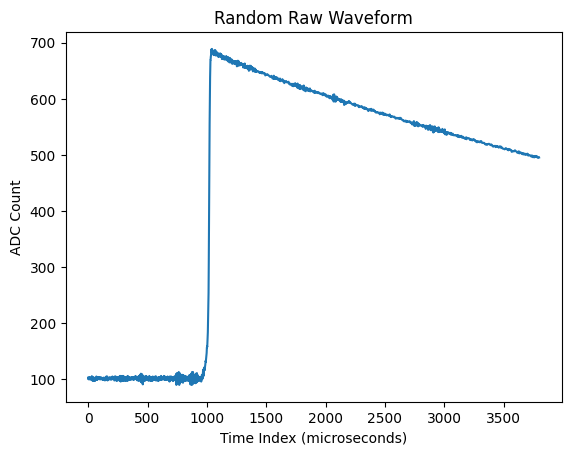

In [6]:
fig, ax = plt.subplots()
ax.plot(time_index, random_waveform)
ax.set_title("Random Raw Waveform")
ax.set_xlabel("Time Index (microseconds)")
ax.set_ylabel("ADC Count")

print("Data Labels:")
print(f"Energy: {energy_value}")
print(f"PSD Low Avse: {psd_low_avse_value}")
print(f"PSD High Avse: {psd_high_avse_value}")
print(f"PSD DCR: {psd_dcr_value}")
print(f"PSD LQ: {psd_lq_value}")
print(f"TP0: {tp0_value}")
print(f"Detector: {detector_value}")
print(f"Run Number: {run_number_value}")
print(f"ID: {id_value}")

In [7]:
waveform = random_waveform

In [8]:
#Now we find tp0

#method 1: basic threshold

def find_baseline(waveform):
    #determines baseline from first 100 microseconds of waveform
    return sum(waveform[:100]) / 100

def find_tp0_method1(waveform, threshold):
    tp0 = np.argwhere(waveform > (find_baseline(waveform) + threshold))[0][0]
    return tp0

tp0_method1 = find_tp0_method1(waveform, 30)
tp0_method1


np.int64(975)

In [9]:
#method 2: slope

def find_tp0_method2(waveform, slope_threshold):
    waveform_gradient = np.gradient(waveform)
    waveform_gradient_baseline = find_baseline(waveform_gradient)
    waveform_gradient_threshold = waveform_gradient_baseline + slope_threshold
    return find_tp0_method1(waveform_gradient, waveform_gradient_threshold)
tp0_method2 = find_tp0_method2(waveform, 12)
tp0_method2


np.int64(999)

In [10]:
#method 3: gradient start of peak
from scipy.signal import find_peaks, peak_widths, savgol_filter

waveform_gradient = np.gradient(waveform)

smoothed_waveform_gradient = savgol_filter(waveform_gradient, window_length=100, polyorder=3)

peaks, _ = find_peaks(smoothed_waveform_gradient, height=max(smoothed_waveform_gradient/2))
widths, height_levels, left_ips, right_ips = peak_widths(smoothed_waveform_gradient, peaks, rel_height=0.95)

tp0_method3 = int(left_ips[0])
tp0_method3

967

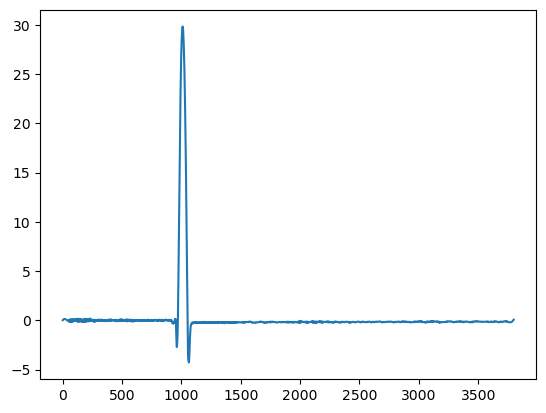

In [26]:
waveform_gradient = np.gradient(waveform)

smoothed_waveform_gradient = savgol_filter(waveform_gradient, window_length=100, polyorder=3)
fig, ax = plt.subplots()
ax.plot(time_index, smoothed_waveform_gradient)

In [12]:
print(f"Basic threshold tp0: {tp0_method1}")
print(f"Slope threshold tp0: {tp0_method2}")
print(f"Gradient peak start tp0: {tp0_method3}")
print(f"Ground truth tp0: {tp0_value}")

Basic threshold tp0: 975
Slope threshold tp0: 999
Gradient peak start tp0: 967
Ground truth tp0: 958


In [13]:
estimated_tp0 = tp0_method3
peak_value = max(waveform)
peak_index = np.where(waveform == peak_value)[0][0]
waveform_rise = waveform[estimated_tp0:peak_index+1]
timeindex_rise = np.arange(0, peak_index - estimated_tp0 + 1)


In [14]:
from scipy.interpolate import interp1d

interpolated_waveform_function = interp1d(timeindex_rise, waveform_rise)
new_timeindex_rise = np.arange(0, len(timeindex_rise) - 1, 0.1)
new_waveform_rise = interpolated_waveform_function(new_timeindex_rise)


In [15]:
rise_peak = max(new_waveform_rise)
tdrift = np.where(new_waveform_rise >= (0.999 * rise_peak))[0][0]
tdrift50 = np.where(new_waveform_rise >= (0.5 * rise_peak))[0][0]
tdrift10 = np.where(new_waveform_rise >= (0.1 * rise_peak))[0][0]

In [16]:
print(f"tdrift: {tdrift}")
print(f"tdrift50: {tdrift50}")
print(f"tdrift10: {tdrift10}")

tdrift: 754
tdrift50: 440
tdrift10: 241


In [17]:
#pole zero correction
from scipy.optimize import curve_fit
def exponential(t, a, tau1, b, tau2):
    return a * np.exp(-t/tau1) + b * np.exp(-t/tau2)

peak_value = max(waveform)
t98 = np.where(waveform >= 0.98 * peak_value)[0][0]
tail_time = np.arange(0,time_index[-1] - t98 + 1)
tail_values = waveform[t98:]

params, params_cov = curve_fit(exponential, tail_time, tail_values)

f_decay = exponential(tail_time, *params)
f_t0 = np.mean(waveform[t98:t98+5])
f_pz = f_t0 / f_decay
waveform_tail_corrected = tail_values * f_pz

waveform_pz = waveform.copy()
waveform_pz[t98:] = waveform_tail_corrected

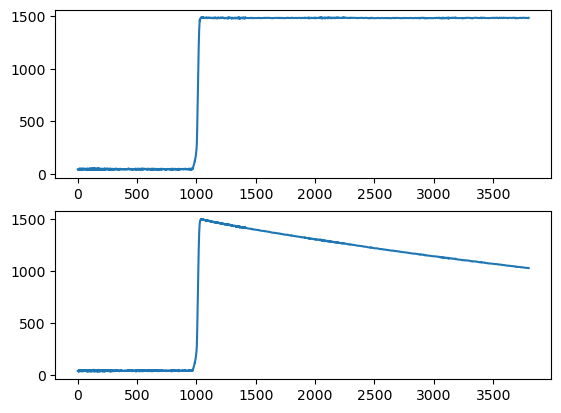

In [18]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(time_index, waveform_pz)
ax[1].plot(time_index, waveform)

In [19]:
#now to find lq80
tail_average = np.mean(waveform_tail_corrected)
t80 = np.where(waveform >= 0.80 * peak_value)[0][0]
tpeak = np.where(waveform >= peak_value)[0][0]

lq80_region = waveform[t80:tpeak+1]
tail_mean_threshold = np.ones(len(lq80_region)) * tail_average

waveform_underlq80 = np.trapezoid(lq80_region)
tail_mean_area = np.trapezoid(tail_mean_threshold)

lq80_region = tail_mean_area - waveform_underlq80

lq80_region


np.float64(895.338930514059)